In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [3]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [5]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [6]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Close   1259 non-null   float64
 2   Volume  1259 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.6+ KB


**Data Time Period**

In [7]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2024-04-19')

## Visualize the data

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [10]:
train = df.loc[df['Date'] <= '2023-12-24']
test = df.loc[df['Date'] > '2023-12-24']
train.shape, test.shape

((1179, 3), (80, 3))

In [11]:
train[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


#### 2. Data Scaling

In [12]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close','Volume']])

scaled_train = scaler.transform(train[['Close','Volume']])
scaled_test= scaler.transform(test[['Close', 'Volume']])

train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])
test_df = pd.DataFrame(scaled_test,columns = ['Close','Volume'])

In [13]:
train_df.head()

,Close,Volume
0,-1.334878,-1.009316
1,-1.307831,-0.219925
2,-1.322551,-0.683611
3,-1.309725,-0.547324
4,-1.294695,-0.340813


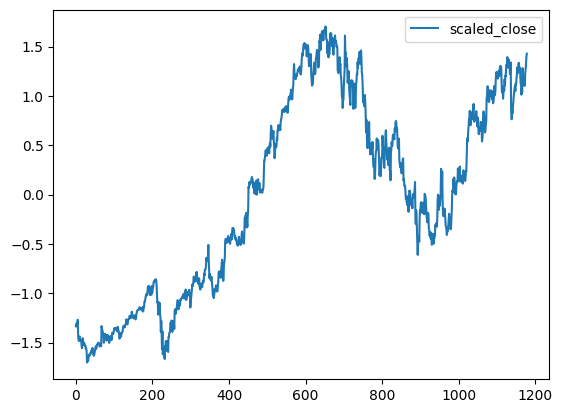

In [14]:
# Visualize scaled data
plt.plot(train_df['Close'], label = 'scaled_close')
plt.legend()
plt.show()

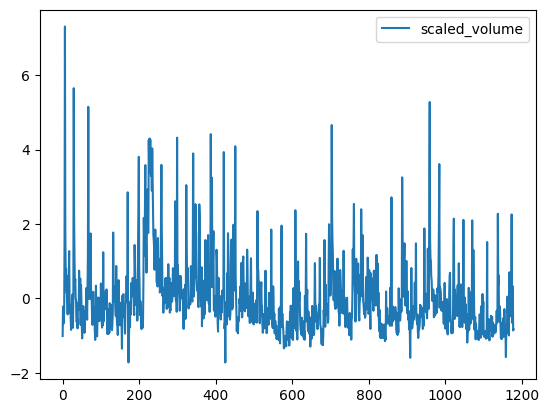

In [15]:
plt.plot(train_df['Volume'], label = 'scaled_volume')
plt.legend()
plt.show()

In [16]:
# def generate_data(num_samples, time_steps, num_features):
#     data = np.random.normal(0, 1, (num_samples, time_steps, num_features))
#     return data

# num_samples = 10
# time_steps = 5
# num_features = 3
# data = generate_data(num_samples, time_steps, num_features)
# data.shape

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [17]:
# def create_sequences(data, time_steps):
#     num_features = data.shape[1]
#     # Create sequences with time steps
#     sequences = []
#     for i in range(len(data) - time_steps + 1):
#         sequence = data[i:i + time_steps]
#         sequences.append(sequence)

#     # Convert sequences to numpy array
#     sequences = np.array(sequences)

#     # Reshape the array to have dimensions (samples, time steps, features)
#     reshaped_data = sequences.reshape(-1, time_steps, num_features)
#     return reshaped_data

# TIME_STEPS = 30

# X_train, y_train = create_sequences(train, TIME_STEPS) , np.array(train[TIME_STEPS:])
# X_test, y_test = create_sequences(test,TIME_STEPS) ,np.array(test[TIME_STEPS:])


# print("Training input shape: ", X_train.shape)
# print("Testing input shape: ", X_test.shape)

In [18]:
def generate_datasets_for_training(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  return np.array(Xs), np.array(Ys)

In [19]:
TIME_STEPS = 30
X_train, Y_train= generate_datasets_for_training(train_df, TIME_STEPS)
X_test, Y_test= generate_datasets_for_training(test_df, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)
print("Training input shape: ", Y_train.shape)
print("Testing input shape: ", Y_test.shape)

Training input shape:  (1149, 30, 2)
Testing input shape:  (50, 30, 2)
Training input shape:  (1149, 30, 2)
Testing input shape:  (50, 30, 2)


In [79]:
X_test.shape

(50, 30, 2)

In [20]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 2`.

In [21]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation = 'tanh'))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, activation = 'tanh', return_sequences=True))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

e:\AIO\AnamolyDetection_NLP_Time_Series\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 2)          │           258 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,578 (971.01 KB)

 Trainable params: 248,578 (971.01 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [22]:
history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.9459 - val_loss: 0.4568
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.7154 - val_loss: 0.3490
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.7771 - val_loss: 0.3312
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.6251 - val_loss: 0.4311
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.5665 - val_loss: 0.3049
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.5652 - val_loss: 0.3116
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.5143 - val_loss: 0.3075
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.5371 - val_loss: 0.3143
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.5304 - val_loss: 0.2933
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.5425 - val_loss: 0.2727


#### Plot Training - Validation loss

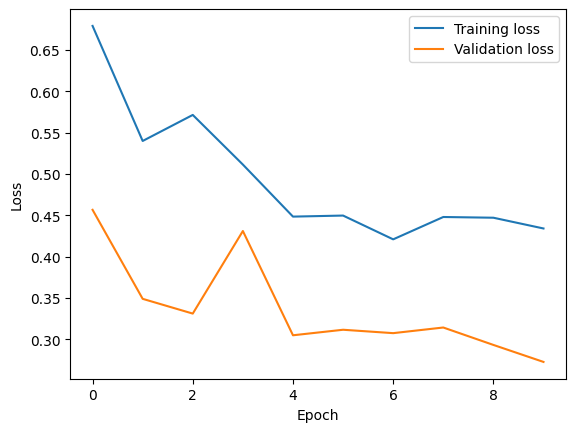

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


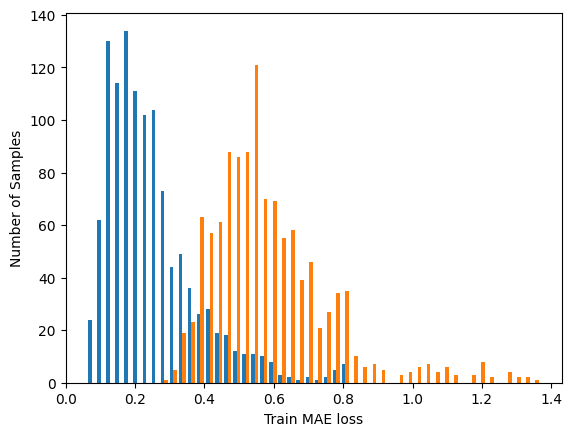

In [25]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

## Predict Anomalies on test data using threshold

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Reconstruction error threshold for close: 0.35503507006592755
Reconstruction error threshold for volume: 0.5665518474896262


Text(0, 0.5, 'Number of samples')

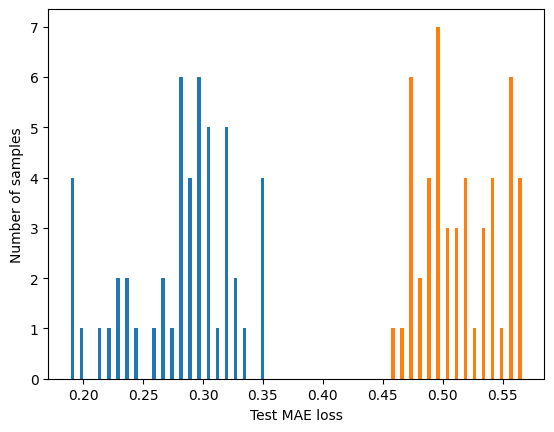

In [70]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

max_values = np.max(test_mae_loss, axis=0)
close_threshold = max_values[0]
volume_threshold = max_values[1]


print('Reconstruction error threshold for close:',close_threshold)
print('Reconstruction error threshold for volume:',volume_threshold)

# #Add some buffer
# # Set reconstruction error threshold
# close_threshold = close_threshold - 0.05*close_threshold
# volume_threshold = volume_threshold - 0.05*volume_threshold

# print('Reconstruction error threshold for close:',close_threshold)
# print('Reconstruction error threshold for volume:',volume_threshold)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [77]:
new_df = pd.read_csv('Stocks\TestAnomaly.csv')
new_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/20/2024,150.320007,151.304993,148.009995,148.740005,148.740005,19843900
1,4/21/2024,150.240005,152.559998,150.089996,151.770004,151.770004,19226300
2,4/22/2024,150.949997,151.455994,148.800003,151.149994,151.149994,15114700
3,4/23/2024,151.240005,153.199997,151.029999,151.699997,151.699997,19312700
4,4/24/2024,152.145004,152.690002,150.130005,151.940002,151.940002,16622000
5,4/25/2024,152.000000,152.669998,151.330002,152.259995,152.259995,21105600
6,4/26/2024,151.830002,157.000000,151.649994,156.500000,156.500000,24469800
7,4/27/2024,154.750000,155.990005,153.460007,155.869995,155.869995,17598100
8,4/28/2024,154.919998,156.550003,154.132004,156.369995,156.369995,17266200
9,4/29/2024,155.080002,156.179993,151.880005,151.940002,151.940002,24184800


In [ ]:
new_test_pred = model.predict(X_test, verbose=1)

In [71]:
anomaly_df = test[TIME_STEPS:]
print(anomaly_df.head())
print(len(anomaly_df))

            Date       Close    Volume
1209  2024-02-08  147.220001  18241300
1210  2024-02-09  150.220001  21877700
1211  2024-02-12  148.729996  17236100
1212  2024-02-13  146.369995  18138500
1213  2024-02-14  147.139999  16651800
50


In [72]:
test_mae_loss_df = pd.DataFrame(test_mae_loss, columns=['Close_Loss','Volume_Loss'])

anomaly_df['Close_Loss'] = np.array(test_mae_loss_df['Close_Loss'])
anomaly_df['Volume_Loss'] = np.array(test_mae_loss_df['Volume_Loss'])
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_33992\343152502.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ragam\AppData\Local\Temp\ipykernel_33992\343152502.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss
1209,2024-02-08,147.220001,18241300,0.189625,0.555934
1210,2024-02-09,150.220001,21877700,0.188941,0.539836
1211,2024-02-12,148.729996,17236100,0.192571,0.529056
1212,2024-02-13,146.369995,18138500,0.193150,0.516472
1213,2024-02-14,147.139999,16651800,0.200128,0.507990


In [73]:
print(test_mae_loss_df['Close_Loss'].max())
print(test_mae_loss_df['Volume_Loss'].max())

0.35503507006592755
0.5665518474896262


In [74]:
anomaly_df['anomaly'] = np.where((anomaly_df['Close_Loss'] > close_threshold) | (anomaly_df['Volume_Loss'] > volume_threshold), True, False)
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_33992\3343482539.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
1209,2024-02-08,147.220001,18241300,0.189625,0.555934,False
1210,2024-02-09,150.220001,21877700,0.188941,0.539836,False
1211,2024-02-12,148.729996,17236100,0.192571,0.529056,False
1212,2024-02-13,146.369995,18138500,0.193150,0.516472,False
1213,2024-02-14,147.139999,16651800,0.200128,0.507990,False


In [75]:
anomaly_df['anomaly'].value_counts()

anomaly
False    50
Name: count, dtype: int64

In [76]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close_Loss'], name='Close loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Volume_Loss'], name='Volume loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([close_threshold]*len(anomaly_df)), name='Close Threshold'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([volume_threshold]*len(anomaly_df)), name='Volume Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [43]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
1209,2024-02-08,147.220001,18241300,0.189625,0.555934,True
1210,2024-02-09,150.220001,21877700,0.188941,0.539836,True
1228,2024-03-07,135.240005,24107300,0.348280,0.510400,True
1229,2024-03-08,136.289993,26472400,0.355035,0.496564,True
1230,2024-03-11,138.940002,22536400,0.351805,0.481618,True


In [67]:
source_data = scaler.inverse_transform(anomaly_df[['Close', 'Volume']])

anomaly_data = scaler.inverse_transform(anomalies[['Close','Volume']])


In [68]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,0], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,0], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [69]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,1], name='Volume'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,1], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()